In [131]:
import os
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [132]:
import pandas as pd
import os
splits = {}
for split_name in ['train', 'validation', 'test']:
    csv_path = f"../../data/saved_splits/laroseda/{split_name}.csv"
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        splits[split_name] = {
            'index': df['index'].tolist(),
            'title': df['title'].tolist(),
            'content': df['content'].tolist(),
            'starRating': df['starRating'].tolist(),
        }

In [133]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

MODEL_ROOT = "laroseda_embeddings"
strategies = ["classical-avg", "classical-last", "echo-avg", "summary-avg"]
fields = ["title", "content", "title+content"]
models = [
    "meta-llama/Meta-Llama-3-8B",
    "OpenLLM-Ro/RoLlama3.1-8b-Instruct",
    "ai-forever/mGPT-1.3B-romanian",
    "faur-ai/LLMic"
]

In [134]:
def load_embeddings(path):
    if path.endswith(".pt"):
        return torch.load(path)
    elif path.endswith(".npy"):
        return torch.tensor(np.load(path))
    else:
        raise ValueError("Unsupported file format")

def get_labels(star_ratings):
    return torch.tensor([0 if r <= 2 else 1 for r in star_ratings if r in [1, 2, 4, 5]])

In [152]:
from sklearn.metrics import confusion_matrix
def train_mlp_classifier(X_train, y_train, X_val, y_val, input_dim, device):
    import torch.nn as nn
    import torch.optim as optim

    class MLP(nn.Module):
        def __init__(self, input_dim):
            super().__init__()
            self.fc = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )

        def forward(self, x):
            return self.fc(x)

    model = MLP(input_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(20):
        model.train()
        optimizer.zero_grad()
        out = model(X_train)
        loss = criterion(out, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = torch.sigmoid(model(X_val)).squeeze() > 0.5
        acc = accuracy_score(y_val.cpu().numpy(), val_preds.cpu().numpy())
        f1 = f1_score(y_val.cpu().numpy(), val_preds.cpu().numpy())

    return model, acc, f1

def run_all_classifiers(root_dir, splits):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {}

    strategies = ["classical-avg", "classical-last", "echo-avg", "summary-avg"]
    fields = ["title", "content", "title+content"]

    for model_name in os.listdir(root_dir): 
            model_path = os.path.join(root_dir, model_name)

            for strategy in strategies:
                for field in fields:
                    try:
                        print(f"Running MLP for: {model_name} / {strategy} / {field}")
    
                        def load_split(split):
                            path = os.path.join(model_path, strategy, field, split, "embeddings.npy")
                            return load_embeddings(path)
    
                        X_train = load_split("train")
                        y_train = [1 if r >= 4 else 0 for r in splits['train']['starRating']]
    
                        X_val = load_split("validation")
                        y_val = [1 if r >= 4 else 0 for r in splits['validation']['starRating']]
    
                        X_test = load_split("test")
                        y_test = [1 if r >= 4 else 0 for r in splits['test']['starRating']]
    
                        if not (len(X_train) == len(y_train) and len(X_val) == len(y_val)):
                            print("Length mismatch, skipping.")
                            continue
                        
                        X_train = X_train.float().to(device)
                        X_val = X_val.float().to(device)
                        X_test = X_test.float().to(device)

                       
                        y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
                        y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
                        y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)
                        model, acc, f1 = train_mlp_classifier(X_train, y_train, X_val, y_val, X_train.shape[1], device)
 
                        # Retrain on full data
                        X_trainval = torch.cat([X_train, X_val], dim=0)
                        y_trainval = torch.cat([y_train, y_val], dim=0)
                        final_model, _, _ = train_mlp_classifier(X_trainval, y_trainval, X_val, y_val, X_train.shape[1], device)
                        
                        # Evaluate on test
                        final_model.eval()
                        with torch.no_grad():
                            test_preds = torch.sigmoid(final_model(X_test)).squeeze() > 0.5
                            y_test_np = y_test.cpu().numpy()
                            test_preds_np = test_preds.cpu().numpy()

                            test_acc = accuracy_score(y_test_np, test_preds_np)
                            test_f1 = f1_score(y_test_np, test_preds_np)
                            test_cm = confusion_matrix(y_test_np, test_preds_np)
                              
                        results[(model_name, strategy, field)] = {
                            "val_acc": acc,
                            "val_f1": f1,
                            "test_acc": test_acc,
                            "test_f1": test_f1
                        }
                        import matplotlib.pyplot as plt
                        import seaborn as sns
                        def plot_confusion_matrix(cm, model_name, strategy, labels=["0 - negative", "1 - positive"]):
                            plt.figure(figsize=(6, 5))
                            sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
                            plt.xlabel("Predicted")
                            plt.ylabel("Actual")
                            plt.title(f"Confusion Matrix: {model_name} / {field} / {strategy}")
                            plt.tight_layout()
                            plt.show()
                        if model_name == "rollama":
                            plot_confusion_matrix(test_cm, model_name, strategy)
                    except Exception as e:
                        print(f"Failed for {model_name}/{strategy}/{field}: {e}")
                        continue

    return results

In [ ]:
results = run_all_classifiers(MODEL_ROOT, splits)

In [137]:
records = []
for (model, strategy, field), scores in results.items():
    row = {
        "Model": model,
        "Strategy": strategy,
        "Field": field,
        "Val Acc": round(scores["val_acc"] * 100, 2),
        "Val F1": round(scores["val_f1"] * 100, 2),
        "Test Acc": round(scores["test_acc"] * 100, 2),
        "Test F1": round(scores["test_f1"] * 100, 2),
    }
    records.append(row)

df = pd.DataFrame(records)
df_sorted = df.sort_values(by=["Test Acc", "Test F1"], ascending=False)
df_sorted


,Model,Strategy,Field,Val Acc,Val F1,Test Acc,Test F1
47,rollama,summary-avg,title+content,95.92,95.78,97.23,97.23
11,llama3,summary-avg,title+content,97.08,97.03,96.73,96.75
9,llama3,summary-avg,title,96.42,96.48,96.33,96.33
42,rollama,echo-avg,title,96.50,96.55,96.30,96.28
45,rollama,summary-avg,title,97.42,97.41,96.23,96.17
36,rollama,classical-avg,title,96.42,96.43,96.07,96.10
39,rollama,classical-last,title,95.75,95.84,95.93,96.01
6,llama3,echo-avg,title,95.92,95.93,95.60,95.51
41,rollama,classical-last,title+content,94.75,94.59,95.47,95.38
46,rollama,summary-avg,content,95.25,95.15,95.43,95.42


In [138]:
import pandas as pd

# Filter for LaRoSeDa — assumed all rows are LaRoSeDa; if needed, apply additional filter here

# Group by Model and Strategy, averaging over all fields
avg_results = (
    df.groupby(["Model", "Strategy"])["Test F1"]
    .mean()
    .unstack()
    .round(2)
    .fillna("-")
    .reindex(index=["llama3", "rollama", "mgpt", "llmic"])  # Ensure row order
)

# Optional: Rename for display purposes
avg_results.index = ["LLaMA3.1-8B", "RoLLaMA3.1-8B", "mGPT1.3B", "LLMic 3B"]
avg_results.columns = ["Last", "Mean", "Echo", "Summ"]

# Display the table
print(avg_results)


                Last   Mean   Echo   Summ
LLaMA3.1-8B    89.72  93.55  92.74  95.92
RoLLaMA3.1-8B  93.91  94.89  93.73  96.27
mGPT1.3B       89.25  87.31  88.05  88.70
LLMic 3B       63.20  44.60  69.40  44.45


In [139]:
import pandas as pd

# Filter for rows where Field is "title"
df_title = df[df["Field"] == "title"]

# Group by Model and Strategy for title only
avg_results_title = (
    df_title.groupby(["Model", "Strategy"])["Test F1"]
    .mean()
    .unstack()
    .round(2)
    .fillna("-")
    .reindex(index=["llama3", "rollama", "mgpt", "llmic"])
)

# Rename rows and columns for presentation
avg_results_title.index = ["LLaMA3.1-8B", "RoLLaMA3.1-8B", "mGPT1.3B", "LLMic 3B"]
avg_results_title.columns = ["Last", "Mean", "Echo", "Summ"]

# Display
print(avg_results_title)


                Last   Mean   Echo   Summ
LLaMA3.1-8B    94.74  94.53  95.51  96.33
RoLLaMA3.1-8B  96.10  96.01  96.28  96.17
mGPT1.3B       94.70  94.29  93.97  93.48
LLMic 3B       42.12  66.67  79.55   0.00


In [140]:
# Compute average Test F1 for each strategy across all models
strategy_avgs = avg_results_title.replace("-", pd.NA).astype(float).mean(axis=0)

# Get the best strategy name
best_strategy = strategy_avgs.idxmax()
best_score = strategy_avgs.max()

print("Average Test F1 per Strategy:")
print(strategy_avgs.round(2))
print(f"\nBest Strategy Overall: {best_strategy} (Avg F1 = {best_score:.2f})")

Average Test F1 per Strategy:
Last    81.91
Mean    87.88
Echo    91.33
Summ    71.50
dtype: float64

Best Strategy Overall: Echo (Avg F1 = 91.33)


In [141]:
import pandas as pd

# Filter for rows where Field is "title"
df_title = df[df["Field"] == "content"]

# Group by Model and Strategy for title only
avg_results_content = (
    df_title.groupby(["Model", "Strategy"])["Test F1"]
    .mean()
    .unstack()
    .round(2)
    .fillna("-")
    .reindex(index=["llama3", "rollama", "mgpt", "llmic"])
)

# Rename rows and columns for presentation
avg_results_content.index = ["LLaMA3.1-8B", "RoLLaMA3.1-8B", "mGPT1.3B", "LLMic 3B"]
avg_results_content.columns = ["Last", "Mean", "Echo", "Summ"]

# Display
print(avg_results_content)

                Last   Mean   Echo   Summ
LLaMA3.1-8B    81.67  92.66  90.05  94.68
RoLLaMA3.1-8B  90.46  93.27  90.46  95.42
mGPT1.3B       82.48  82.20  82.13  81.30
LLMic 3B       80.71   0.00  61.97  66.67


In [142]:
import pandas as pd

# Filter for rows where Field is "title"
df_title = df[df["Field"] == "title+content"]

# Group by Model and Strategy for title only
avg_results_title_content = (
    df_title.groupby(["Model", "Strategy"])["Test F1"]
    .mean()
    .unstack()
    .round(2)
    .fillna("-")
    .reindex(index=["llama3", "rollama", "mgpt", "llmic"])
)

# Rename rows and columns for presentation
avg_results_title_content.index = ["LLaMA3.1-8B", "RoLLaMA3.1-8B", "mGPT1.3B", "LLMic 3B"]
avg_results_title_content.columns = ["Last", "Mean", "Echo", "Summ"]

# Display
print(avg_results_title_content)

                Last   Mean   Echo   Summ
LLaMA3.1-8B    92.74  93.45  92.67  96.75
RoLLaMA3.1-8B  95.17  95.38  94.46  97.23
mGPT1.3B       90.56  85.44  88.05  91.31
LLMic 3B       66.76  67.13  66.67  66.67


In [128]:
# Compute average Test F1 for each strategy across all models
strategy_avgs = avg_results.replace("-", pd.NA).astype(float).mean(axis=0)

# Get the best strategy name
best_strategy = strategy_avgs.idxmax()
best_score = strategy_avgs.max()

print("Average Test F1 per Strategy:")
print(strategy_avgs.round(2))
print(f"\nBest Strategy Overall: {best_strategy} (Avg F1 = {best_score:.2f})")


Average Test F1 per Strategy:
Last    88.24
Mean    85.32
Echo    83.22
Summ    75.95
dtype: float64

Best Strategy Overall: Last (Avg F1 = 88.24)


In [112]:
best_model_overall = df.groupby("Model")["Test F1"].mean().sort_values(ascending=False)
print(" Best Models Overall (by avg Test F1):")
print(best_model_overall.round(4))

 Best Models Overall (by avg Test F1):
Model
rollama    94.6150
llama3     93.3550
mgpt       88.3175
llmic      46.6817
Name: Test F1, dtype: float64


In [151]:
best_strategy_overall = df.groupby("Strategy")["Test F1"].mean().sort_values(ascending=False)
print("\n Best Strategies Overall (by avg Test F1):")
print(best_strategy_overall.round(4))


 Best Strategies Overall (by avg Test F1):
Strategy
echo-avg          85.9808
classical-avg     84.0175
summary-avg       81.3342
classical-last    80.0858
Name: Test F1, dtype: float64


In [129]:
best_field = df.groupby("Field")["Test F1"].mean().idxmax()
print(f"\nBest Field (by avg Test F1): {best_field}")

df_best_field = df[df["Field"] == best_field]

best_strategy_on_best_field = df_best_field.groupby("Strategy")["Test F1"].mean().sort_values(ascending=False)
print("\nBest Strategies on Best Field (by avg Test F1):")
print(best_strategy_on_best_field.round(4))

top_strategy = best_strategy_on_best_field.idxmax()
print(f"\nTop Strategy on Best Field '{best_field}': {top_strategy}")



Best Field (by avg Test F1): title

Best Strategies on Best Field (by avg Test F1):
Strategy
classical-avg     91.5100
echo-avg          91.0625
summary-avg       88.4600
classical-last    87.6000
Name: Test F1, dtype: float64

Top Strategy on Best Field 'title': classical-avg


In [115]:
best_model_run = df_best_field.loc[df_best_field["Test F1"].idxmax()]
print("\nBest Model on Best Field (single best run):")
print(best_model_run)


Best Model on Best Field (single best run):
Model           rollama
Strategy    summary-avg
Field             title
Val Acc           97.25
Val F1            97.29
Test Acc           96.7
Test F1           96.71
Name: 45, dtype: object


In [116]:
# Average across strategies for each model (still only on best field)
best_model_across_strats = df_best_field.groupby("Model")["Test F1"].mean().sort_values(ascending=False)

print("\nBest Models on Best Field (average across strategies):")
print(best_model_across_strats.round(4))

top_model_avg = best_model_across_strats.idxmax()
print(f"\nTop Model on Best Field '{best_field}' (averaged across strategies): {top_model_avg}")



Best Models on Best Field (average across strategies):
Model
rollama    96.1675
llama3     95.1350
mgpt       94.2025
llmic      56.1775
Name: Test F1, dtype: float64

Top Model on Best Field 'title' (averaged across strategies): rollama


In [96]:
print("\n---  Best Strategy per Model ---")
grouped = df.groupby(["Model", "Strategy"])["Test F1"].mean().reset_index()
best_strategies = grouped.sort_values("Test F1", ascending=False).groupby("Model").first().reset_index()
print(best_strategies.to_string(index=False))


---  Best Strategy per Model ---
  Model      Strategy   Test F1
 llama3   summary-avg 95.950000
  llmic classical-avg 67.116667
   mgpt   summary-avg 88.823333
rollama   summary-avg 96.383333


In [56]:
best_field_overall = df.groupby("Field")["Test F1"].mean().sort_values(ascending=False)
print("Best Field Overall (by avg Test F1):")
print(best_field_overall.round(4))

Best Field Overall (by avg Test F1):
Field
title            81.5112
content          77.5156
title+content    76.6769
Name: Test F1, dtype: float64


In [57]:
best_field_per_model = (
    df.groupby(["Model", "Field"])["Test F1"]
    .mean()
    .reset_index()
    .sort_values(["Test F1"], ascending=[False])
    .groupby("Model")
    .first()
)
print("\n Best Field by Model (by avg Test F1):")
print(best_field_per_model.round(4))


 Best Field by Model (by avg Test F1):
           Field  Test F1
Model                    
llama3     title  95.2975
llmic    content  45.0600
mgpt       title  94.2875
rollama    title  96.2900


In [39]:
pip install matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [58]:
model_names = {
    "llama3": "Llama-3.1-8B-Instruct",
    "rollama": "RoLlama3.1-8b-Instruct",
    "mgpt": "mGPT-1.3B-romanian",
    "llmic": "faur-ai/LLMic"
}
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pandas as pd

def plot_tsne_for_field(field, embedding_root="laroseda_embeddings", 
                        best_model="rollama", 
                        strategies=["classical-avg", "classical-last", "echo-avg", "summary-avg"],
                        label_path="../../data/saved_splits/laroseda/test.csv", max_samples=3000):

    labels = pd.read_csv(label_path)['starRating'].tolist()
    binary_labels = [1 if r >= 4 else 0 for r in labels if r in [1, 2, 4, 5]]
    binary_labels = np.array(binary_labels[:max_samples])

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, strategy in enumerate(strategies):
        emb_path = os.path.join(embedding_root, best_model, strategy, field, "test", "embeddings.npy")
        if not os.path.exists(emb_path):
            print(f"Missing: {strategy}")
            continue

        X = np.load(emb_path)[:max_samples]

        if len(X) != len(binary_labels):
            print(f"Mismatch for {strategy}, skipping.")
            continue

        X_scaled = StandardScaler().fit_transform(X)
        X_embedded = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_scaled)

        ax = axes[idx]
        ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=binary_labels, cmap='coolwarm', s=10, alpha=0.6)
        ax.set_title(f"{strategy}")

    plt.suptitle(f"t-SNE Visualization ({model_names[best_model]}, {field})")
    plt.tight_layout()
    plt.show()

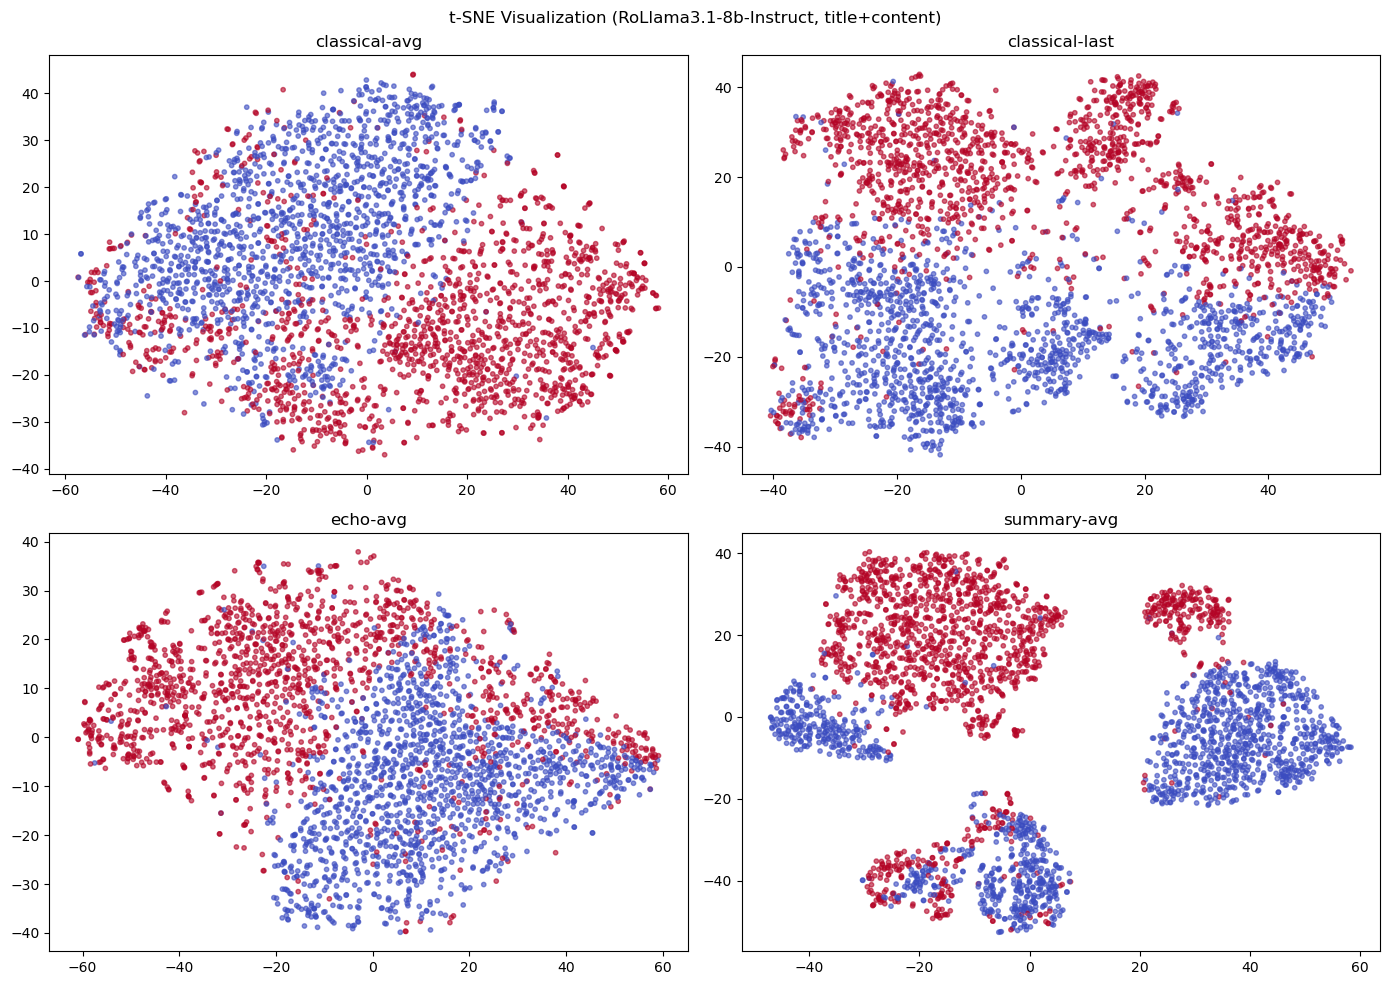

In [ ]:

# plot_tsne_for_field("content")
plot_tsne_for_field("title+content")

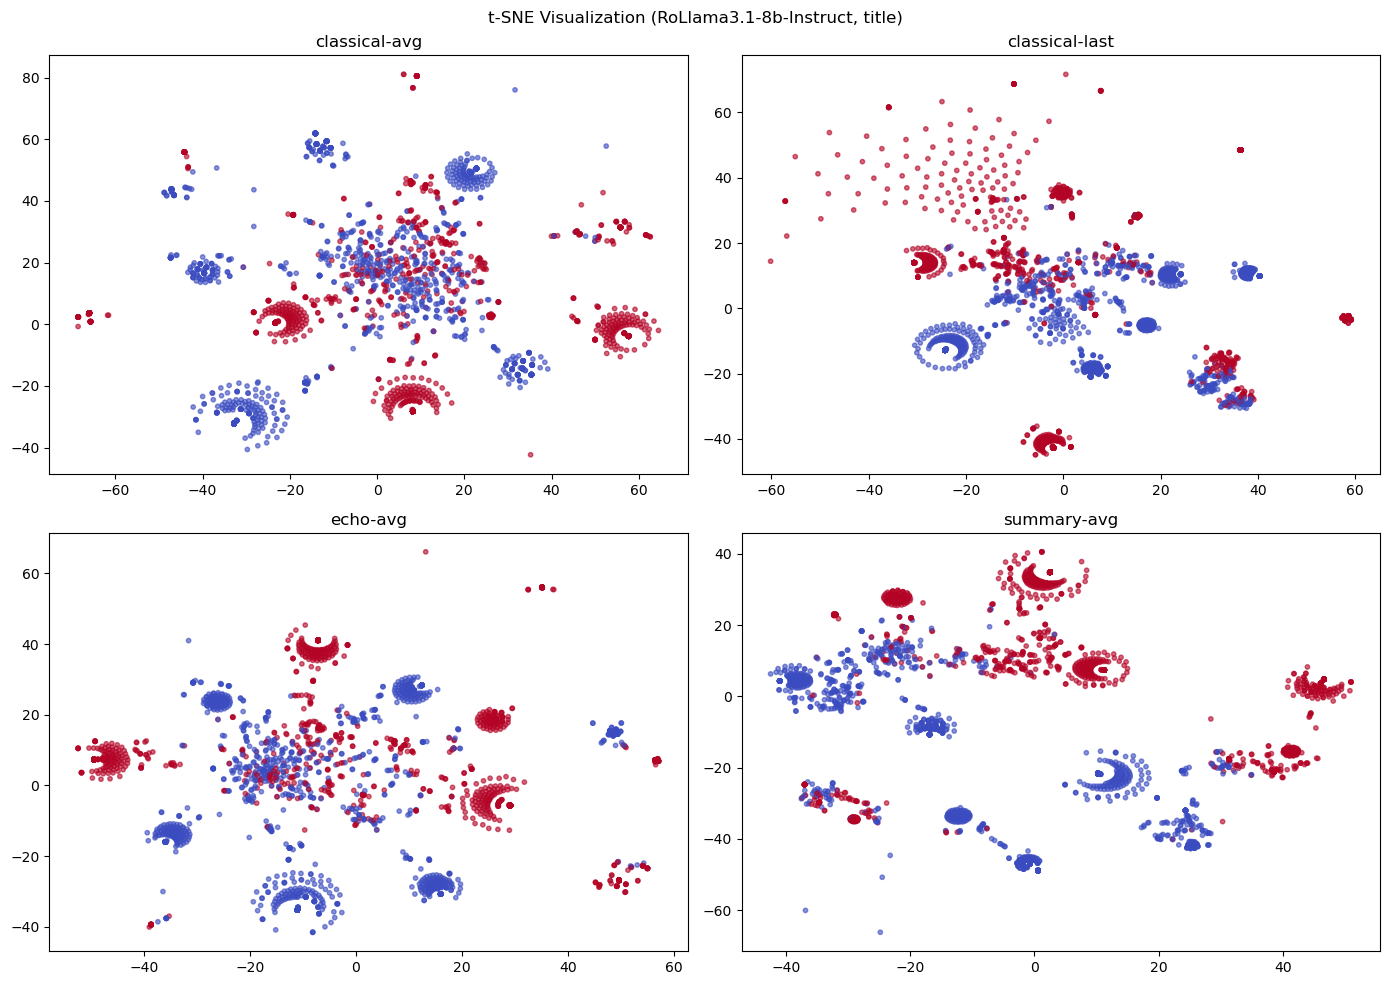

In [59]:
plot_tsne_for_field("title")

In [17]:
df.to_csv("df_laroseda_results.csv")